In [2]:
import pandas as pd
import numpy as np
import re
import string
import joblib 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Load dataset
df = pd.read_csv("searchactivitydataset.csv")

# Display first few rows
print(df.head())


                         Search_Query               Category  \
0       Python tutorial for beginners    Educational-related   
1  Microsoft Excel advanced functions           Work-related   
2              Upcoming Marvel movies  Entertainment-related   
3         Best upcoming PC games 2025         Gaming-related   
4     Top 10 travel destinations 2025                  Other   

   Platform_Context          Source  \
0          Learning  Firefox Search   
1  Professional Use     Edge Search   
2   Casual Browsing          Chrome   
3            Gaming   Google Search   
4   Casual Browsing     Bing Search   

                                            Metadata  
0  Firefox Search: Python Tutorial | Learn Python...  
1   Edge Search: Top MS Excel Formulas and Functions  
2        Chrome: Upcoming New Marvel Movies for 2025  
3   Google Search: Upcoming PC games 2025 and beyond  
4      Bing Search: Best destinations to Travel 2025  


In [74]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
Search_Query            0
Cleaned_Search_Query    0
dtype: int64


In [77]:
# Drop rows with missing values
df.dropna(inplace=True)
print("Dataset shape after dropping missing values:", df.shape)

Dataset shape after dropping missing values: (3, 2)


In [38]:
# Define text cleaning function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenization
    tokens = [word for word in tokens if word not in stopwords.words("english")]  # Remove stopwords
    return " ".join(tokens)

# Apply preprocessing
df["Cleaned_Search_Query"] = df["Search_Query"].apply(preprocess_text)
# Check if the column is properly created
print(df[["Search_query", "Cleaned_Search_Query"]].head())

In [10]:
# Convert text into numerical vectors using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["Cleaned_Search_Query"])

# Encode category labels
y = df["Category"]

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [41]:
# Train Naïve Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_preds = nb_model.predict(X_test)

# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

# Train Decision Tree model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)


In [44]:
print("Naïve Bayes Model Accuracy:", accuracy_score(y_test, nb_preds))
print("Logistic Regression Model Accuracy:", accuracy_score(y_test, lr_preds))
print("Decision Tree Model Accuracy:", accuracy_score(y_test, dt_preds))

print("\nClassification Report for Best Model:")
print(classification_report(y_test, lr_preds))  # Assuming Logistic Regression is best


Naïve Bayes Model Accuracy: 1.0
Logistic Regression Model Accuracy: 1.0
Decision Tree Model Accuracy: 1.0

Classification Report for Best Model:
                       precision    recall  f1-score   support

  Educational-related       1.00      1.00      1.00       149
Entertainment-related       1.00      1.00      1.00       133
       Gaming-related       1.00      1.00      1.00       153
                Other       1.00      1.00      1.00       107
         Work-related       1.00      1.00      1.00       175

             accuracy                           1.00       717
            macro avg       1.00      1.00      1.00       717
         weighted avg       1.00      1.00      1.00       717



In [47]:
import joblib

# Save the trained model and vectorizer
joblib.dump(lr_model, "search_activity_classifier.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

# Load the model and vectorizer for prediction
model = joblib.load("search_activity_classifier.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")


In [50]:
def predict_category(query):
    query_cleaned = preprocess_text(query)  # Preprocess the query
    query_vectorized = vectorizer.transform([query_cleaned])  # Convert to TF-IDF vector
    prediction = model.predict(query_vectorized)[0]  # Get prediction
    return prediction


In [53]:
# Test with new queries
queries = [
    "Best Python courses online",
    "Upcoming Marvel movies 2025",
    "How to use Excel pivot tables",
    "Live Fortnite tournament",
    "Top healthy breakfast ideas"
]

for query in queries:
    category = predict_category(query)
    print(f"Search Query: {query} → Predicted Category: {category}")


Search Query: Best Python courses online → Predicted Category: Gaming-related
Search Query: Upcoming Marvel movies 2025 → Predicted Category: Entertainment-related
Search Query: How to use Excel pivot tables → Predicted Category: Work-related
Search Query: Live Fortnite tournament → Predicted Category: Work-related
Search Query: Top healthy breakfast ideas → Predicted Category: Other


In [56]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained model and vectorizer
model = joblib.load("search_activity_classifier.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")


In [59]:
def predict_category(queries):
    cleaned_queries = [preprocess_text(q) for q in queries]  # Preprocess text
    vectorized_queries = vectorizer.transform(cleaned_queries)  # Convert to TF-IDF vectors
    predictions = model.predict(vectorized_queries)  # Get predictions
    return list(zip(queries, predictions))


In [62]:
def visualize_predictions(queries):
    predictions = predict_category(queries)
    
    # Convert to DataFrame
    df_preds = pd.DataFrame(predictions, columns=["Search Query", "Predicted Category"])

    # Plot count of each category
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df_preds, y="Predicted Category", order=df_preds["Predicted Category"].value_counts().index, hue="Predicted Category", palette="coolwarm", legend=False)
    plt.xlabel("Count")
    plt.ylabel("Predicted Category")
    plt.title("Prediction Results for New Queries")
    plt.show()

    return df_preds


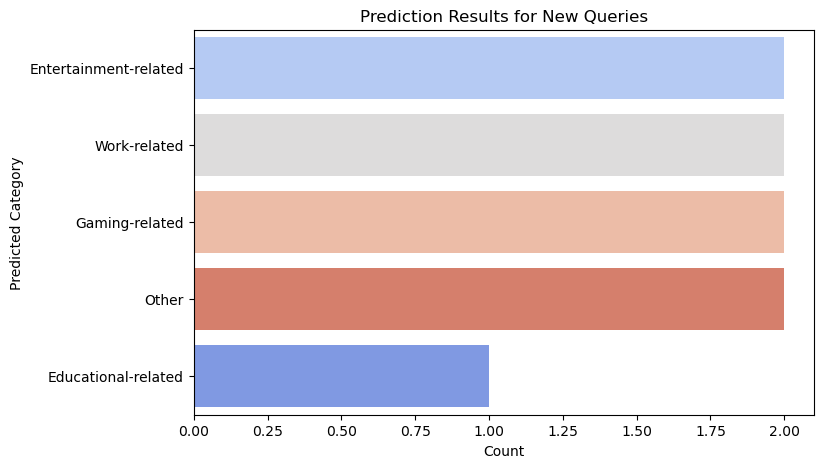

                         Search Query     Predicted Category
0       Python tutorial for beginners    Educational-related
1              Upcoming Marvel movies  Entertainment-related
2  Microsoft Excel advanced functions           Work-related
3         Best upcoming PC games 2025         Gaming-related
4     Top 10 travel destinations 2025                  Other
5             Project management tips           Work-related
6      Latest Bollywood movie reviews  Entertainment-related
7             GTA V online heist tips         Gaming-related
8     Easy 5-minute breakfast recipes                  Other


In [67]:
# Sample new search queries
test_queries = [
    "Python tutorial for beginners",
    "Upcoming Marvel movies",
    "Microsoft Excel advanced functions",
    "Best upcoming PC games 2025",
    "Top 10 travel destinations 2025",
    "Project management tips",
    "Latest Bollywood movie reviews",
    "GTA V online heist tips",
    "Easy 5-minute breakfast recipes"
]

# Run predictions & visualize results
df_predictions = visualize_predictions(test_queries)
print(df_predictions)
